<a href="https://colab.research.google.com/github/PaoDeVi/Paralela/blob/main/Blur_y_GreyScale_de_im%C3%A1genes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Thu Nov  9 21:40:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!apt-get update
!apt-get install g++
!apt-get install cuda-9.2

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,463 kB]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,274 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 3,079 kB in 2s (1,490 kB/s)
Reading package li

In [ ]:
# Instalar opencv
!apt-get -qq install -y libopencv-dev

In [ ]:
!curl --output 'Imagen.jpg' 'https://static01.nyt.com/images/2013/03/25/arts/bioshock/bioshock-superJumbo.jpg'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  507k  100  507k    0     0  2057k      0 --:--:-- --:--:-- --:--:-- 2064k


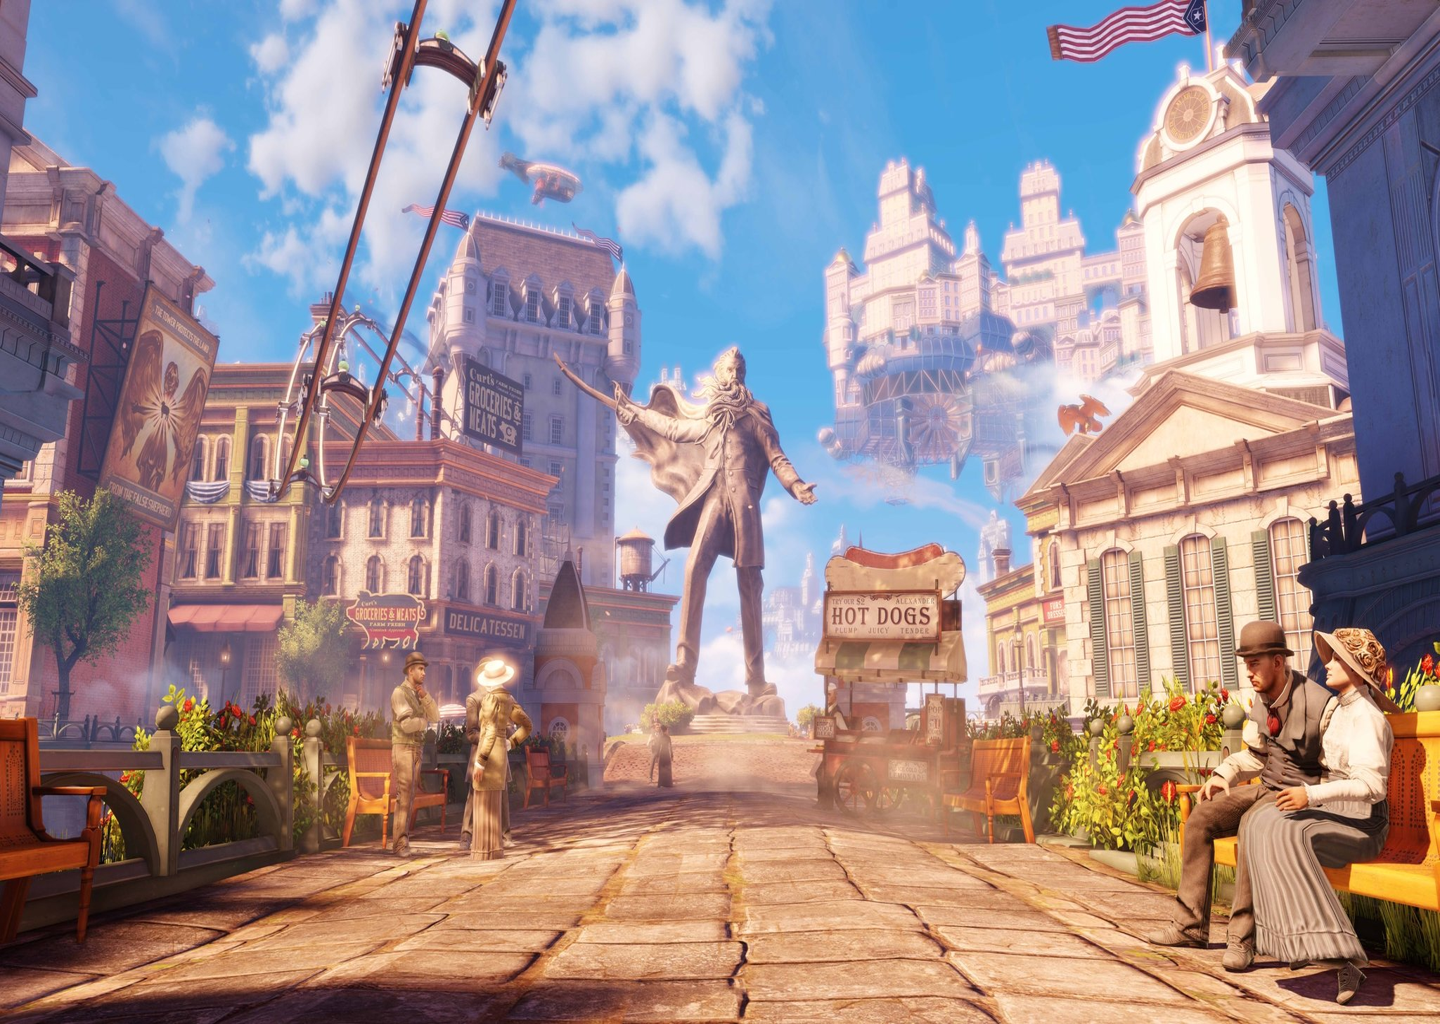

In [ ]:
from PIL import Image
import ipywidgets as widgets
from IPython import display

img = Image.open('Imagen.jpg').resize((1440, 1024))
display.display(img)

In [ ]:
%%writefile grey.cu

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <cuda.h>
#include <opencv2/core/core.hpp>
#include <opencv2/imgproc/imgproc.hpp>
#include <opencv2/highgui/highgui.hpp>
#include <opencv2/opencv.hpp>
#include <opencv2/imgcodecs.hpp>
#include "device_launch_parameters.h"


#define CV_LOAD_IMAGE_COLOR cv::IMREAD_COLOR

using namespace cv;
using namespace std;


__global__ void grayScale(unsigned char* Pout, unsigned char* Pin, int width, int height) {
    // compute global thread coordinates
    int row = threadIdx.y + blockIdx.y*blockDim.y;
    int col = threadIdx.x + blockIdx.x*blockDim.x;

    // linearize coordinates for data access
    int grayOffset = row * width + col;
    int colorOffset = grayOffset * 3;

    if ((col < width) && (row < height)) {
        Pout[grayOffset] = (0.21 * Pin[colorOffset + 2]) +
                           (0.71 * Pin[colorOffset + 1]) +
                           (0.07 * Pin[colorOffset]);
    }
}

int main(int argc, char *argv[]) {
    if (argc == 1) {
        printf("[!] Filename expected.\n");
        return 0;
    }

    // read image
    Mat image;
    image = imread(argv[1], CV_LOAD_IMAGE_COLOR);
    if (image.empty()) {
        printf("Cannot read image file %s", argv[1]);
        exit(1);
    }

    // define img params
    int imageWidth = image.cols;
    int imageHeight = image.rows;
    size_t size_rgb = sizeof(unsigned char)*imageWidth*imageHeight*3;
    size_t size_gray = sizeof(unsigned char)*imageWidth*imageHeight;

    // allocate mem for host image vectors
    unsigned char* h_grayImage = (unsigned char*)malloc(size_rgb);

    // grab pointer to host rgb image
    unsigned char* h_rgbImage = image.data;

    // allocate mem for device rgb and gray
    unsigned char* d_rgbImage;
    unsigned char* d_grayImage;

    cudaMalloc((void**)&d_rgbImage, size_rgb);
    cudaMalloc((void**)&d_grayImage, size_gray);

    // copy the rgb image from the host to the device

    cudaMemcpy(d_rgbImage, h_rgbImage, size_rgb, cudaMemcpyHostToDevice);

    // execution configuration parameters + kernel launch
    dim3 dimBlock(16, 16, 1);
    dim3 dimGrid(ceil(imageWidth/16.0), ceil(imageHeight/16.0), 1);
    grayScale<<<dimGrid, dimBlock>>>(d_grayImage, d_rgbImage, imageWidth, imageHeight);

    // copy gray image from device to host
    cudaMemcpy(h_grayImage, d_grayImage, size_gray, cudaMemcpyDeviceToHost);

    Mat Image1(imageHeight, imageWidth, CV_8UC1, h_grayImage);

    imwrite("ImagenGrises.jpg", Image1);

    // free host and device memory
    image.release();
    Image1.release();
    free(h_grayImage);
    cudaFree(d_rgbImage); cudaFree(d_grayImage);

    return 0;
}

Overwriting grey.cu


In [ ]:
! nvcc -I/usr/include/opencv4 -L/usr/lib -o grey grey.cu -lopencv_core -lopencv_highgui -lopencv_imgcodecs
!./grey Imagen.jpg

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::MultiBandBlender"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially ov

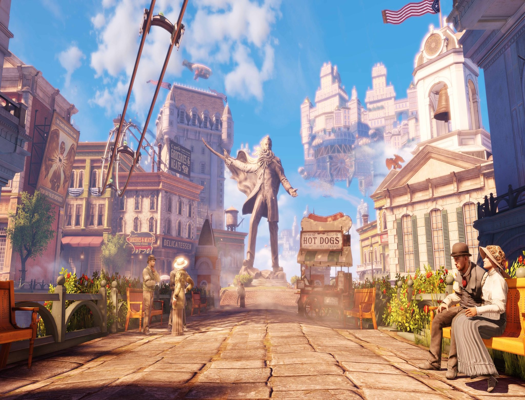

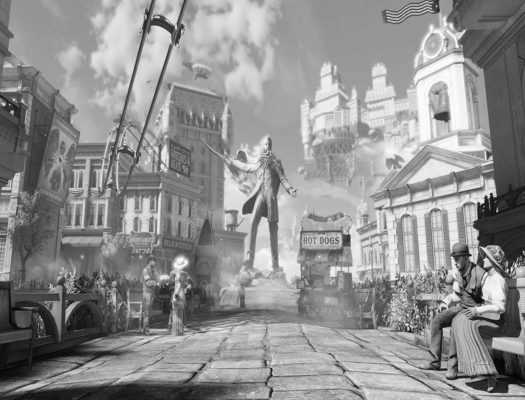

In [ ]:
import ipywidgets as widgets
from IPython.display import display
from PIL import Image

imagen1 = Image.open('Imagen.jpg').resize((525, 400))
imagen2 = Image.open('ImagenGrises.jpg').resize((525, 400))

display(imagen1)
print()
display(imagen2)

In [ ]:
%%writefile blur.cu
#include <opencv2/core/core.hpp>
#include <opencv2/imgproc/imgproc.hpp>
#include <opencv2/highgui/highgui.hpp>
#include<opencv2/opencv.hpp>
#include <iostream>
#include <cuda_runtime.h>
#include "device_launch_parameters.h"

using namespace cv;
using namespace std;

#define CV_LOAD_IMAGE_COLOR cv::IMREAD_COLOR
#define CV_LOAD_IMAGE_GRAYSCALE cv::IMREAD_GRAYSCALE
#define FILTER_SIZE 11


__global__ void Blur(unsigned char* outImg, unsigned char* inImg, int width, int height) {
    int filterRow, filterCol;
    int cornerRow, cornerCol;
    int tx = threadIdx.x; int ty = threadIdx.y;
    int bx = blockIdx.x; int by = blockIdx.y;
    int filterSize = 2*FILTER_SIZE + 1;

    // compute global thread coordinates
    int row = by * blockDim.y + ty;
    int col = bx * blockDim.x + tx;

    // make sure thread is within image boundaries
    if ((row < height) && (col < width)) {
        // instantiate accumulator
        int numPixels = 0;
        int cumSum = 0;

        // top-left corner coordinates
        cornerRow = row - FILTER_SIZE;
        cornerCol = col - FILTER_SIZE;

        // accumulate values inside filter
        for (int i = 0; i < filterSize; i++) {
            for (int j = 0; j < filterSize; j++) {
                // filter coordinates
                filterRow = cornerRow + i;
                filterCol = cornerCol + j;

                // accumulate sum
                if ((filterRow >= 0) && (filterRow <= height) && (filterCol >= 0) && (filterCol <= width)) {
                    cumSum += inImg[filterRow*width + filterCol];
                    numPixels++;
                }
            }
        }
        // set the value of output
        outImg[row*width + col] = (unsigned char)(cumSum / numPixels);
    }
}

int main(int argc, char *argv[]) {
    // make sure filename given
    if (argc == 1) {
        printf("[!] Filename expected.\n");
        return 0;
    }

    // read image
    Mat img;
    img = imread(argv[1], CV_LOAD_IMAGE_GRAYSCALE);
    if (img.empty()) {
        printf("Cannot read image file %s", argv[1]);
        exit(1);
    }

    // define img params
    int imgWidth = img.cols;
    int imgHeight = img.rows;
    size_t imgSize = sizeof(unsigned char)*imgWidth*imgHeight;


    // allocate mem for host output image vectors
    unsigned char* h_outImg = (unsigned char*)malloc(imgSize);

    // grab pointer to host input image
    unsigned char* h_inImg = img.data;

    // allocate mem for device input and output
    unsigned char* d_inImg;
    unsigned char* d_outImg;

    cudaMalloc((void**)&d_inImg, imgSize);
    cudaMalloc((void**)&d_outImg, imgSize);

    // copy the input image from the host to the device

    cudaMemcpy(d_inImg, h_inImg, imgSize, cudaMemcpyHostToDevice);

    // execution configuration parameters + kernel launch
    dim3 dimBlock(16, 16, 1);
    dim3 dimGrid(ceil(imgWidth/16.0), ceil(imgHeight/16.0), 1);

    Blur<<<dimGrid, dimBlock>>>(d_outImg, d_inImg, imgWidth, imgHeight);

    // copy output image from device to host

    cudaMemcpy(h_outImg, d_outImg, imgSize, cudaMemcpyDeviceToHost);

    Mat Image1(imgHeight, imgWidth, CV_8UC1, h_outImg);
    imwrite("ImagenBlur.jpg", Image1);

    // free host and device memory
    img.release();
    Image1.release();
    cudaFree(d_outImg); cudaFree(d_inImg);
    return 0;
}

Overwriting blur.cu


In [ ]:
! nvcc -I/usr/include/opencv4 -L/usr/lib -o blur blur.cu -lopencv_core -lopencv_highgui -lopencv_imgcodecs
!./blur Imagen.jpg

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::MultiBandBlender"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially ov

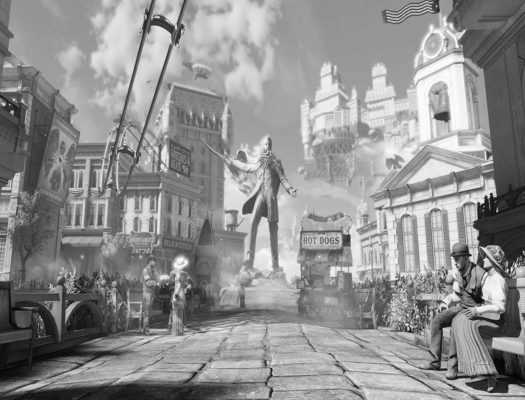

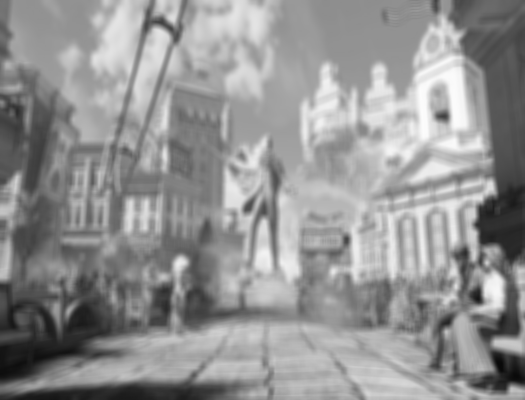

In [ ]:
import ipywidgets as widgets
from IPython.display import display
from PIL import Image

imagen1 = Image.open('ImagenGrises.jpg').resize((525, 400))
imagen2 = Image.open('ImagenBlur.jpg').resize((525, 400))

display(imagen1)
print()
display(imagen2)